In [10]:
import pandas as pd
import numpy as np 
import io

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import clear_output


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import accuracy_score

In [16]:
def stacking(groups):
    X_group = np.empty(shape=[0, max_length])
    y_group = np.empty(shape=[0, 2])
    for i in range(len(groups)):
        hash_ = np.array([[]])
        group = groups[i]
        group = group.drop('hash', axis = 1)
        for index, row in group.iterrows():
            hash_ = np.append(hash_,np.array([row[:]]))
  
        y_group = np.r_[y_group,np.array([hash_[np.shape(hash_)[0]-2:np.shape(hash_)[0]]])] # putting the output away
        hash_ = np.delete(hash_,[np.shape(hash_)[0]-2,np.shape(hash_)[0]-1]) # removing the output
  
        num_pad = max_length - np.shape(hash_)[0] # padding with 0s
        hash_ = np.append(hash_,np.zeros(num_pad))
  
        X_group = np.r_[X_group,np.array([hash_])] # changing dimemsions of hash_
    return X_group, y_group


def stacking_by_chunks(df):
    df = df.drop('trajectory_id',axis = 1)
    grouped = df.groupby('hash')
    X = np.empty(shape=[0, max_length])
    y = np.empty(shape=[0, 2])  
    num_groups = grouped['hash'].unique().count()
    num_iter = 100
    chunk_size = int(num_groups/num_iter)
    #last_chunk = num_groups - chunk_size*num_iter
    
    for i in range(1,num_iter+1):
        groups = [g[1] for g in list(grouped)[(i-1)*chunk_size:i*chunk_size]]
        X_group, y_group = stacking(groups)
        X = np.r_[X,X_group]
        y = np.r_[y,y_group]
    
    groups = [g[1] for g in list(grouped)[num_iter*chunk_size:num_groups]] 
    #last chunk
    X_group, y_group = stacking(groups)
    X = np.r_[X,X_group]
    y = np.r_[y,y_group]
    
    return X,y

def city(y):
    city = np.array([[]])
    for i in range(np.shape(y)[0]):
        if y[i][0] > 3750901.5068 and y[i][0] < 3770901.5068 and y[i][1] > -19268905.6133 and y[i][1] < -19208905.6133:
            city = np.append(city,1)
        else:
            city = np.append(city,0)
    return city  


# Loading data

In [11]:
X_train = pd.read_csv('X_train.csv',index_col=0)
y_train = pd.read_csv('y_train.csv',index_col=0)
X_train = pd.DataFrame(X_train.loc[0:4000])
y_train = pd.DataFrame(y_train.loc[0:4000])

# Model1:random forest
First split the data into 80:20 to find the best 5 models; then use these models to predict on test data for submission 

In [7]:
# spliting test/train data 
train_size = int(0.8*np.shape(X_train)[0])
test_size = np.shape(X_train)[0]-train_size
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, train_size=train_size, test_size=test_size, random_state=4)

# random forest
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=200,max_depth=100,random_state=0,verbose=True))
regr_multirf.fit(X_train, y_train)
# Predict on new data
y_multirf = regr_multirf.predict(X_test)

# random forest non-multioutput 
#regr_rf = RandomForestRegressor(n_estimators=100, max_depth=100,
                            #    random_state=2)
#regr_rf.fit(X_train, y_train, verbose = 1)
# predict on new data
#y_rf = regr_rf.predict(X_test)



KeyboardInterrupt: 

In [ ]:
# accuracy 
print (classification_report(city(y_test), city(y_multirf),digits = 4))
print (confusion_matrix(city(y_test), city(y_multirf)))
print (accuracy_score(city(y_test), city(y_multirf)))

# plotting 
plt.figure()
s = 20
a = 0.8
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_multirf[:, 0], y_multirf[:, 1], edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
y_test = np.array(y_test)
ax.scatter(y_test[:, 0], y_test[:, 1], edgecolor='k',
            c="red", s=s, marker="s", alpha=a, label="Data")
rect = patches.Rectangle((3750901.5068,-19268905.6133),20000,60000,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

# Model2: gradient boosting

In [12]:
# gradient boosting 
regr_multigbr = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=200,max_depth=100,random_state=0,verbose=True))
regr_multigbr.fit(X_train, y_train)
# Predict on new data
y_multigbr = regr_multigbr.predict(X_test)

      Iter       Train Loss   Remaining Time 
         1    68785568.7105            7.64m
         2    55716310.6555            7.53m
         3    45130211.6310            7.43m
         4    36555471.4211            7.36m
         5    29609931.8511            7.30m
         6    23984044.7994            7.25m
         7    19427076.2875            7.21m
         8    15735931.7929            7.16m
         9    12746104.7522            7.13m
        10    10324344.8493            7.08m
        20     1255199.3076            6.70m
        30      152602.9327            6.33m
        40       18552.9540            5.95m
        50        2255.6061            5.58m
        60         274.2290            5.20m
        70          33.3398            4.83m
        80           4.0533            4.46m
        90           0.4928            4.09m
       100           0.0599            3.70m
       200           0.0000            0.00s
      Iter       Train Loss   Remaining Time 
        

             precision    recall  f1-score   support

        0.0     0.8849    0.8881    0.8865      5816
        1.0     0.6992    0.6924    0.6958      2185

avg / total     0.8342    0.8346    0.8344      8001

[[5165  651]
 [ 672 1513]]
0.8346456692913385


<Figure size 432x288 with 0 Axes>

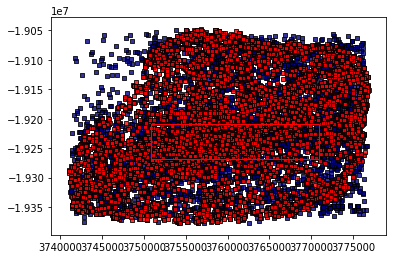

In [18]:
# accuracy 
y_test = np.array(y_test)
print (classification_report(city(y_test), city(y_multigbr),digits = 4))
print (confusion_matrix(city(y_test), city(y_multigbr)))
print (accuracy_score(city(y_test), city(y_multigbr)))

# plotting 
plt.figure()
s = 20
a = 0.8
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_multigbr[:, 0], y_multigbr[:, 1], edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
ax.scatter(y_test[:, 0], y_test[:, 1], edgecolor='k',
            c="red", s=s, marker="s", alpha=a, label="Data")
rect = patches.Rectangle((3750901.5068,-19268905.6133),20000,60000,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

## Cat Boost 

In [21]:
# gradient boosting 
regr_multigbr = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=200,max_depth=100,random_state=0,verbose=True,loss ='huber'))
regr_multigbr.fit(X_train, y_train)
# Predict on new data
y_multigbr = regr_multigbr.predict(X_test)

      Iter       Train Loss   Remaining Time 
         1    34459562.5520            8.56m
         2    27913376.5246            8.36m
         3    22611146.5186            8.19m
         4    18316053.9898            8.09m
         5    14836966.6042            8.01m
         6    12018744.0103            7.95m
         7     9735724.2876            7.88m
         8     7886371.3943            7.83m
         9     6388427.4354            7.78m
        10     5175057.0695            7.74m
        20      629704.5608            7.32m
        30       76749.8647            6.91m
        40        9425.5385            6.51m
        50        1181.8324            6.11m
        60         155.5508            5.70m
        70          22.2234            5.29m
        80           3.3594            4.87m
        90           0.5836            4.45m
       100           0.1074            4.03m
       200           0.0001            0.00s
      Iter       Train Loss   Remaining Time 
        

             precision    recall  f1-score   support

        0.0     0.8818    0.8924    0.8870      5816
        1.0     0.7040    0.6815    0.6926      2185

avg / total     0.8332    0.8348    0.8339      8001

[[5190  626]
 [ 696 1489]]
0.8347706536682915


<Figure size 432x288 with 0 Axes>

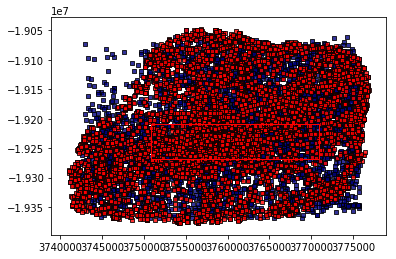

In [22]:
# accuracy 
y_test = np.array(y_test)
print (classification_report(city(y_test), city(y_multigbr),digits = 4))
print (confusion_matrix(city(y_test), city(y_multigbr)))
print (accuracy_score(city(y_test), city(y_multigbr)))

# plotting 
plt.figure()
s = 20
a = 0.8
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_multigbr[:, 0], y_multigbr[:, 1], edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
ax.scatter(y_test[:, 0], y_test[:, 1], edgecolor='k',
            c="red", s=s, marker="s", alpha=a, label="Data")
rect = patches.Rectangle((3750901.5068,-19268905.6133),20000,60000,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

# Model3: minibatch 

In [ ]:
from sklearn.linear_model import SGDRegressor
 
def iter_minibatches(chunksize):
    # Provide chunks one by one
  chunkstartmarker = 0
  while chunkstartmarker < numtrainingpoints:
    chunkrows = range(chunkstartmarker,chunkstartmarker+chunksize)
    X_chunk, y_chunk = getrows(chunkrows)
    yield X_chunk, y_chunk
    chunkstartmarker += chunksize

def main():
  batcherator = iter_minibatches(chunksize=1000)
  model = SGDRegressor()
 # Train model
  for X_chunk, y_chunk in batcherator:
    model.partial_fit(X_chunk, y_chunk)
 # Now make predictions with trained model
  y_predicted = model.predict(X_test)

# final model

In [99]:
X_test = pd.read_csv('X_test.csv',index_col=0)
X_test = pd.DataFrame(X_test)
y_predict = regr_multigbr.predict(X_test)
# downloading results
result = pd.DataFrame(city(y_predict))

hash_names = pd.DataFrame(pd.read_csv('data_test.csv'))
hash_names = hash_names[hash_names["x_exit"].isna()]["trajectory_id"]
hash_names = pd.DataFrame(hash_names).values.flatten()
hash_names = pd.DataFrame(hash_names)

results = pd.concat([hash_names, result],axis =1)
results.to_csv('Final_Results.csv')
results.head()

,0,0
0,traj_00032f51796fd5437b238e3a9823d13d_31_5,0.0
1,traj_000479418b5561ab694a2870cc04fd43_25_10,0.0
2,traj_000506a39775e5bca661ac80e3f466eb_29_5,1.0
3,traj_0005401ceddaf27a9b7f0d42ef1fbe95_1_4,0.0
4,traj_00063a4f6c12e1e4de7d876580620667_3_4,0.0
